# Putting IPEDS Completions Data into Panels for Institution-Level Trends Analysis

The U.S. Department of Education's Integrated Postseconday Educational Data System (IPEDS) is a rich source of public data for education researchers, labor economists, HR analysts, or anyone interested in the supply of skilled labor.  In particular, the data on the number of degrees awarded by each educational institution (a.k.a. degree "completions") are very useful for anyone who wants to understand the availability of talent with a particular academic background, and how that varies by geographic location, diversity factors (such as ethnicity or gender), and time. 

It's easy enough to download the IPEDS completions data for an individual year.  But what if we want to analyze institution-level changes over time?  Unfortunately, IPEDS has made several changes to its reporting format over the years, including:
* Changes in both file and field naming conventions,
* Differences in which fields are included in which file,
* Inconsistencies in the order of fields across files, and
* Changes to the encoding system of the [Classification of Instructional Programs (CIP)](https://nces.ed.gov/ipeds/cipcode/), which indicates the academic program for which a degree was awarded.

The first half of this iPython notebook contains a script that: 
* Downloads the completions data for every fifth year since 1980 (i.e. 1980, 1985,...2015),
* Standardizes the various file- and field-level differences across the files, and then
* Merges those individual files into one Pandas dataframe with a (year x institution x academic program) panel structure.

The second half of this notebook demonstrates the type of analyses that can be performed on these data.  It uses computer science and related disciplines (CIP codes under category #11) as an example.

### A few notes of caution/interest:
* The mechanism used by the script to download and extract the files relies on iPython "magic" to invoke a bash command.  It won't work if run in a "vanilla" Python environment, and won't work on a Windows box.
* Just to be super-explicit about this:  The script will download a bunch of files and put them on your hard drive, in whatever working directory you've set iPython to use.  On my home internet connection, the downloads take about two minutes. 
* For now, the scope is limited to gender-based breakouts of degree completions (i.e. men vs. women).  Ethnicity-based breakouts are also available in the raw data, and I may add them in the future.
* If all you're interested in are national-level aggregations of the data, this is overkill.  The [Digest of Education Statistics](https://nces.ed.gov/Programs/digest/) contains tables of such aggregates.

### To-dos for later:
* The dataframes created by this script contain CIP codes.  Mapping those to program descriptions is trivial, but due to the ways the CIP has changed over the years, a bit laborious.  Since the analysis is focused on one CIP category, I'm not going to worry about it right now.
* Some analyses may benefit from looking at the data annually (rather than every five years).  Again, this is trivial, but somewhat laborious -- and it uses more RAM and processing time.
* The example analysis below revealed some suspicious looking data for the year 1980.  The integrity of this file should be inspected more thoroughly.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [24]:
url_stub = 'https://nces.ed.gov/ipeds/datacenter/data/'

# We want the completions file for each year divisible by 5 since 1980.
years = [year for year in range(1980, 2016, 5)]

# The first four files don't have a regular pattern to the filenames...
file_stubs = ['c1980_4ormore_cip', 'c1985_cip', 'c8990cip', 'c9495_a']

# ...but the last four do.
file_stubs += ['c' + str(year) + '_a' for year in years[-4:]]

# Now we get each file, unzip it, and save the csv to the working directory
for f in file_stubs:
    request = url_stub + f + '.zip'
    !curl $request | tar -x         # bash command

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  327k  100  327k    0     0   169k      0  0:00:01  0:00:01 --:--:--  169k 0     0   178k      0  0:00:01  0:00:01 --:--:--  178k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  537k  100  537k    0     0   208k      0  0:00:02  0:00:02 --:--:--  208k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  649k  100  649k    0     0   198k      0  0:00:03  0:00:03 --:--:--  198k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1835k  100 1835k    0     0   176k      0  0:00:10  0:00:10 --:--:--  14

In [25]:
# Some of the zip files we unpacked have two versions of the data -- 
# an original version and a revised version (designated with 
# _rv at the end of the filename).

ls = !ls   # bash command, equivalent to os.listdir()

for i, f in enumerate(file_stubs):
    original_filename = f + '.csv'
    revised_filename = f + '_rv.csv'
    
    if revised_filename in ls:
        !rm $original_filename       # cleans up the local directory
        file_stubs[i] = f + '_rv'    # ensures our import in the next chunk will work

filenames = [f + '.csv' for f in file_stubs]

In [26]:
# read in each csv as a pandas dataframe 
# and conform them to a common format

pre2006_cols = ['unitid', 'cipcode', 'awlevel', 'crace15', 'crace16']
post2006_cols = ['UNITID', 'CIPCODE', 'AWLEVEL', 'CTOTALM', 'CTOTALW']
master_cols = [col.lower() for col in post2006_cols]
dfs_dict = {}

for (year, filename) in zip(years, filenames):         
    # for now, we need to preserve the leading zeroes in the CIP codes
    df = pd.read_csv(filename, dtype = {'cipcode': str, 'CIPCODE': str})
    
    # drop excess columns and standardize order
    if year < 2006:
        df = df.reindex(columns= pre2006_cols)
    else:
        df = df.reindex(columns= post2006_cols)
    
    # standardize column naming across all dfs
    df.columns = master_cols
    
    # we need to keep track of year when we concatenate all the dfs
    df.insert(0, 'year', year)  
    
    dfs_dict[year] = df

In [27]:
# check integrity of each df
for year, df in dfs_dict.items():
    print(year)
    print(df.info())
    print(df.head())
    print('\n')

1980
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69719 entries, 0 to 69718
Data columns (total 6 columns):
year       69719 non-null int64
unitid     69719 non-null int64
cipcode    69719 non-null object
awlevel    69719 non-null int64
ctotalm    69719 non-null int64
ctotalw    69719 non-null int64
dtypes: int64(5), object(1)
memory usage: 3.2+ MB
None
   year  unitid cipcode  awlevel  ctotalm  ctotalw
0  1980  100654   01020        5        6        0
1  1980  100654   01030        5        2        0
2  1980  100654   01080        5        0        2
3  1980  100654   01120        5       14        0
4  1980  100654   01130        5       10        1


1985
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116605 entries, 0 to 116604
Data columns (total 6 columns):
year       116605 non-null int64
unitid     116605 non-null int64
cipcode    116605 non-null object
awlevel    116605 non-null int64
ctotalm    116605 non-null int64
ctotalw    116605 non-null int64
dtypes: int64(5),

In [28]:
# Pre-1990 CIP codes were in a different format, let's 
# standardize them.  While we're at it, let's extract 
# the category from the first two digits.

def modernize_cip(cipcode):
    return cipcode[:2] + '.' + cipcode[2:]

def cip_category(cipcode):
    return np.int16(cipcode[:2])



for year, df in dfs_dict.items():
    if year < 1990:
        df['cipcode'] = df['cipcode'].apply(modernize_cip)
    df['cip_category'] = df['cipcode'].apply(cip_category)



In [29]:
completions_df = pd.concat(dfs_dict.values())
completions_df['total'] = completions_df['ctotalm'] + completions_df['ctotalw']
completions_df['pct_women'] = completions_df['ctotalw'] / completions_df['total'] * 100
print(completions_df.info())
print(completions_df.head())

completions_df.to_csv('completions_1980_to_2015.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1448482 entries, 0 to 300262
Data columns (total 9 columns):
year            1448482 non-null int64
unitid          1448482 non-null int64
cipcode         1448482 non-null object
awlevel         1448482 non-null int64
ctotalm         1439230 non-null float64
ctotalw         1441315 non-null float64
cip_category    1448482 non-null int64
total           1432259 non-null float64
pct_women       1243288 non-null float64
dtypes: float64(4), int64(4), object(1)
memory usage: 110.5+ MB
None
   year  unitid cipcode  awlevel  ctotalm  ctotalw  cip_category  total  \
0  1980  100654  01.020        5      6.0      0.0             1    6.0   
1  1980  100654  01.030        5      2.0      0.0             1    2.0   
2  1980  100654  01.080        5      0.0      2.0             1    2.0   
3  1980  100654  01.120        5     14.0      0.0             1   14.0   
4  1980  100654  01.130        5     10.0      1.0             1   11.0   

    pct_w

### Supplementing the data
We now have a master completions dataframe that we can manipulate to get some insights into trends related to a particular institution or academic program. Two things that would help us in our analysis are:
* A rollup of the total number of degrees granted by an institution in a given year, allowing us to calculate the percentage of all degrees awarded at that institution coming from a particular academic major.
* Institutional characteristics, such as whether it's a public vs. private university.

(There are a LOT of other things we could pull in from IPEDS to supplement the data, but let's concentrate on those three for now!)

In [30]:
# grand total degrees awarded by each institution, across 
# all fields and degree levels
uni_degree_totals = pd.pivot_table(
    completions_df,
    index= ['year', 'unitid', 'awlevel'],
    values= ['ctotalm', 'ctotalw', 'total'],
    aggfunc= np.sum)

uni_degree_totals.columns = ['uni_total_men', 'uni_total_women', 'uni_grand_total']


# total bachelors degrees by institution, across all fields 
uni_bachelors_totals = uni_degree_totals.loc[
    uni_degree_totals.index.get_level_values('awlevel') == 5]

uni_bachelors_totals.index = uni_bachelors_totals.index.droplevel(2)

In [31]:
# The last thing we need before we can really analyze the data
# is directory info about the universities, keyed on unitid.

directory_request = url_stub + 'HD2015.zip'
!curl $directory_request | tar -x
uni_dir = pd.read_csv('HD2015.csv', encoding='latin-1')
uni_dir.columns = [c.lower() for c in uni_dir.columns]

# There's a lot of info in the directory, let's keep only fields of interest
uni_dir = uni_dir[['unitid',   
                  'instnm',    
                  'stabbr',   # state abbrev. as string; FIPS code also available 
                  'control',  # see codebook below
                  'hbcu',     # historically black indicator 
                  'longitud',  
                  'latitude']].set_index('unitid')

# mostly because 'longitud' is an annoying name for a field
uni_dir.columns = ['name', 'state', 'control', 'hbcu', 'longitude', 'latitude']

control_codes = {1: 'Public',
                2: 'Private non-profit',
                3: 'For-profit',
                -3: 'Unknown'}

hbcu_codes = {1: 'HBCU',
             2: 'Not an HBCU'}

print(uni_dir.info())



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1065k  100 1065k    0     0   179k      0  0:00:05  0:00:05 --:--:--  200k
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7647 entries, 100654 to 487728
Data columns (total 6 columns):
name         7647 non-null object
state        7647 non-null object
control      7647 non-null int64
hbcu         7647 non-null int64
longitude    7647 non-null object
latitude     7647 non-null object
dtypes: int64(2), object(4)
memory usage: 418.2+ KB
None


### Exploratory data analysis:  Computer Science completions over time
As an example of the type of analysis we can perform on these data, let's look now at bachelor's degrees awarded for computer science and related disciplines (CIP category #11). 

In [32]:
cs_bachelors = completions_df[(completions_df['cip_category'] == 11) &
                             (completions_df['awlevel'] == 5)]
print(cs_bachelors.head())

     year  unitid cipcode  awlevel  ctotalm  ctotalw  cip_category  total  \
86   1980  101709  11.020        5      0.0      1.0            11    1.0   
87   1980  101709  11.050        5      0.0      1.0            11    1.0   
138  1980  100724  11.020        5      0.0      1.0            11    1.0   
139  1980  100724  11.050        5      0.0      1.0            11    1.0   
261  1980  100858  11.020        5      1.0     15.0            11   16.0   

     pct_women  
86      100.00  
87      100.00  
138     100.00  
139     100.00  
261      93.75  


In [33]:
# rollup to one entry per university per year

cs_by_uni = pd.pivot_table(cs_bachelors, 
                            index=['year', 'unitid'],
                            values=['ctotalm', 'ctotalw', 'total'],
                            aggfunc=np.sum)

cs_by_uni.columns = ['cs_ba_men', 'cs_ba_women', 'cs_ba_total']



cs_by_uni = pd.merge(cs_by_uni, uni_bachelors_totals, 
                     how='inner', 
                     left_index=True, 
                     right_index=True)

cs_by_uni['cs_pct_women'] = cs_by_uni['cs_ba_women'] / cs_by_uni['cs_ba_total'] * 100
cs_by_uni['ba_pct_cs'] = cs_by_uni['cs_ba_total'] / cs_by_uni['uni_grand_total'] * 100

cs_by_uni = cs_by_uni.reset_index()

cs_by_uni = cs_by_uni.sort_values(['year', 'cs_ba_total'], 
                                  ascending=[True, False])

cs_by_uni = pd.merge(cs_by_uni, uni_dir, 
                     how='inner', 
                     left_on='unitid',
                     right_index=True, 
                     validate='m:1')

print(cs_by_uni.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9714 entries, 800 to 10121
Data columns (total 16 columns):
year               9714 non-null int64
unitid             9714 non-null int64
cs_ba_men          9714 non-null float64
cs_ba_women        9714 non-null float64
cs_ba_total        9714 non-null float64
uni_total_men      9714 non-null float64
uni_total_women    9714 non-null float64
uni_grand_total    9714 non-null float64
cs_pct_women       9250 non-null float64
ba_pct_cs          9580 non-null float64
name               9714 non-null object
state              9714 non-null object
control            9714 non-null int64
hbcu               9714 non-null int64
longitude          9714 non-null object
latitude           9714 non-null object
dtypes: float64(8), int64(4), object(4)
memory usage: 1.3+ MB
None


There are a lot of universities in the file.  For plotting purposes, we may want to constrain our analysis to institutions that were on the "leaderboard" for most degrees granted at some point over the time series, or perhaps to those that had the highest concentration of students majoring in CS.

In [34]:
top_unis_limit = 20
top_unis_by_size = pd.DataFrame(columns=['unitid', 'name']).set_index('unitid')
top_unis_by_pct = pd.DataFrame(columns=['unitid', 'name']).set_index('unitid')

for year in years:
    biggest_unis= cs_by_uni[cs_by_uni['year'] == year].sort_values(
    'cs_ba_total', ascending=False).iloc[:top_unis_limit, [1,10]].set_index('unitid')
    
    top_unis_by_size = pd.concat([top_unis_by_size, biggest_unis]).drop_duplicates()
    
for year in years:
    mostest_unis = cs_by_uni[cs_by_uni['year'] == year].sort_values(
    'ba_pct_cs', ascending=False).iloc[:top_unis_limit, [1,10]].set_index('unitid')
    
    top_unis_by_pct = pd.concat([top_unis_by_pct, mostest_unis]).drop_duplicates()

top_cs_unis = pd.concat([top_unis_by_size, top_unis_by_pct]).drop_duplicates()
    
print(top_unis_by_size)
print(top_unis_by_pct)


                                               name
unitid                                             
230038               Brigham Young University-Provo
243221        University of Puerto Rico-Rio Piedras
131496                        Georgetown University
110662         University of California-Los Angeles
228778            The University of Texas at Austin
236948      University of Washington-Seattle Campus
151351               Indiana University-Bloomington
186380             Rutgers University-New Brunswick
110635            University of California-Berkeley
240444              University of Wisconsin-Madison
174066          University of Minnesota-Twin Cities
204796            Ohio State University-Main Campus
190664                          CUNY Queens College
170976             University of Michigan-Ann Arbor
234076           University of Virginia-Main Campus
196060                               SUNY at Albany
214777    Pennsylvania State University-Main Campus
110705      

Just scanning those two lists, the largest universities seem reasonable -- we can see several large public universities and technical institutes, as well as a few schools that have sizable distance learning programs (such as Saint Leo and the University of Phoenix).

By contrast, the "most concentrated" list includes a lot of very small institutions.  Given that scoring in the top 20 for any of the years examined "lands" a school on this leaderboard, this measure is sensitive to one-off outliers in the dataset.

So, let's focus our analysis on programs that scored on the "largest" leaderboard:

In [35]:
top_cs_unis_trend = cs_by_uni[cs_by_uni['unitid'].isin(top_unis_by_size.index)]

Now let's look at some data questions!

#### How has the size of university programs changed over time?
At the level of individual universities, has the number of "seats" available in CS programs been growing over time?  One way to check our intuition on this is to look at the institution-level variation in degrees granted:

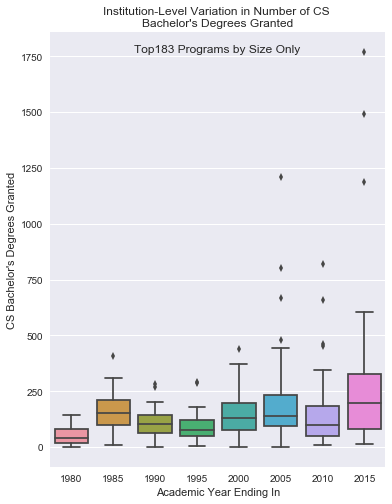

In [36]:
fig, ax = plt.subplots(figsize=(6,8))
sns.boxplot(x='year', 
            y= 'cs_ba_total', 
           data=top_cs_unis_trend)
plt.title("Institution-Level Variation in Number of CS \nBachelor's Degrees Granted")
plt.text(x=1.5, 
         y=np.max(top_cs_unis_trend['cs_ba_total']), 
         s= 'Top' + str(len(top_cs_unis)) + ' Programs by Size Only')
plt.ylabel("CS Bachelor's Degrees Granted")
plt.xlabel('Academic Year Ending In')
plt.show()

Among these large-ish institutions, the median program got smaller from 1985 to 1995.  The average program started to get bigger after that (in conjunction with the 1990s dotcom boom), with the variation in individual program size widening as part of that trend.  The data from 2010 show that trend reversing -- a long-term impact of the dotcom bust in 2001, most likely -- while 2015 shows a dramatic increase in both the size of the median program and the variance in program size.

From the bottoms of the whiskers, we can see that at least one institution graduated no or barely CS students in each of the years, indicating that the size of these programs may not be sustained year-over-year.  (We should keep in mind, however, that this doesn't necessarily mean that the institutions aren't teaching CS anymore -- it may indicate, for example, that CS instruction has been taken over by a department that reports under a different CIP category, such as Math or Electrical Engineering.)

No individual program graduated more that 500 students prior to 2005, which is the first year in the data when we see really extreme outliers.  Inspection of those outliers shows they're all institutions that encapsulate large-scale multi-campus systems, and/or have large distance learning programs:

In [37]:
top_cs_unis_trend.loc[top_cs_unis_trend['cs_ba_total'] > 500,
                     ['year', 'unitid', 'name', 'cs_ba_total']].sort_values(
    ['year', 'cs_ba_total'], ascending=[True, False])

,year,unitid,name,cs_ba_total
6685,2005,445027,American InterContinental University-Online,1210.0
5364,2005,131803,Strayer University-District of Columbia,803.0
5650,2005,163204,University of Maryland-University College,665.0
7730,2010,214777,Pennsylvania State University-Main Campus,818.0
7176,2010,163204,University of Maryland-University College,659.0
10098,2015,484613,University of Phoenix-Arizona,1770.0
8859,2015,163204,University of Maryland-University College,1489.0
9824,2015,433387,Western Governors University,1187.0
9408,2015,214777,Pennsylvania State University-Main Campus,605.0
9920,2015,449339,American Public University System,510.0


#### How does the gender mix of CS programs vary on an institutional level?
Similarly, we might ask whether the decline in the percentage of CS graduates who are women is a problem that spans across multiple institutions, or if it has been concentrated in a few institutions:

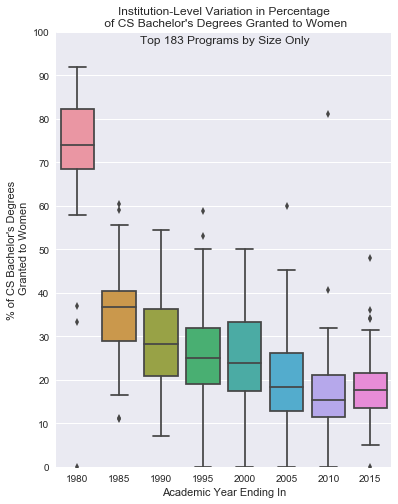

In [38]:
fig, ax = plt.subplots(figsize= (6,8))
sns.boxplot(x='year', 
           y='cs_pct_women',
           data=top_cs_unis_trend)
plt.title("Institution-Level Variation in Percentage\n of CS Bachelor's Degrees Granted to Women")
plt.text(x= 1.5,
        y= 97.5,
        s='Top ' + str(len(top_cs_unis)) + ' Programs by Size Only')
plt.ylim(0, 100)
plt.yticks(np.arange(0, 101, 10))
plt.ylabel("% of CS Bachelor's Degrees\n Granted to Women")
plt.xlabel('Academic Year Ending In')
plt.show()

This reveals an overall declining trend in the average representation of women in CS programs at the institutional level, with only a handful of these programs showing more than 50% representation between 1985 and 2010, and none showing that much representation in 2015.  (And every year since 1995, at least one institution has seen zero women graduate with a CS degree!)

The data from 1980 are extreme enough to warrant a double-check to make sure that there isn't a problem with the raw data file.  (The 1980 completions file is different from all that others in many ways, including the use of a not-quite-documented CIP.)  Beyond that, the institutions that awarded half or more of their CS degrees to women in years after 1980 are worth inspecting as outliers:

In [39]:
top_cs_unis_trend.loc[(top_cs_unis_trend['cs_pct_women'] >= 50) &
                      (top_cs_unis_trend['year'] > 1980),
                     ['year', 'unitid', 'name', 'cs_ba_total', 'cs_pct_women']].sort_values(
    ['year', 'cs_pct_women'], ascending=[True, False])

,year,unitid,name,cs_ba_total,cs_pct_women
1808,1985,243221,University of Puerto Rico-Rio Piedras,124.0,60.483871
1405,1985,190512,CUNY Bernard M Baruch College,193.0,59.067358
1437,1985,194310,Pace University-New York,209.0,55.502392
1229,1985,164739,Bentley University,201.0,50.746269
1024,1985,134097,Florida State University,103.0,50.485437
2877,1990,243221,University of Puerto Rico-Rio Piedras,44.0,54.545455
2024,1990,144740,DePaul University,76.0,51.315789
2406,1990,190512,CUNY Bernard M Baruch College,160.0,50.000000
3025,1995,131803,Strayer University-District of Columbia,34.0,58.823529
3479,1995,190512,CUNY Bernard M Baruch College,145.0,53.103448


#### How has the size of individual programs changed over time?
Or perhaps we'd like to know whether programs that were large in 1985 are still large today:

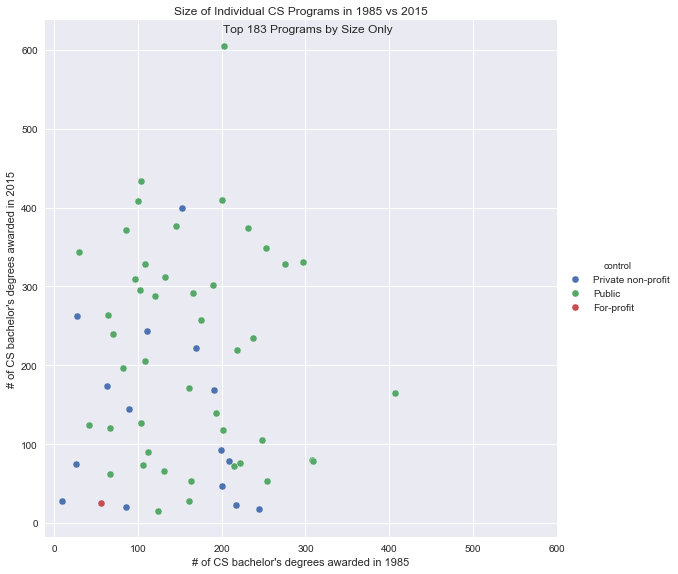

Pearson correlation coefficient: -0.012933234378932049


In [40]:
# flip the data around to a 1985 vs. 2015 comparison for each institution
cs_data_1985 = top_cs_unis_trend.loc[
    top_cs_unis_trend['year'] == 1985].iloc[
    :, 1:].set_index('unitid')

cs_data_2015 = top_cs_unis_trend.loc[
    top_cs_unis_trend['year'] == 2015].iloc[
    :, 1:10].set_index('unitid')

cs_compare_85_15 = pd.merge(cs_data_1985, cs_data_2015, 
                                left_index=True,
                                right_index=True, 
                                suffixes=('_85', '_15'))

cs_compare_85_15['control'] = cs_compare_85_15['control'].apply(lambda c: control_codes[c])


# plot it
scale_limit = max(cs_compare_85_15['cs_ba_total_85'].max(), 
                 cs_compare_85_15['cs_ba_total_15'].max())
scale_ticks = np.arange(0, scale_limit, 100)

sns.pairplot(x_vars=['cs_ba_total_85'],
        y_vars=['cs_ba_total_15'],
        data= cs_compare_85_15,
        hue='control',
        size=8)
plt.title('Size of Individual CS Programs in 1985 vs 2015')
plt.text(x= scale_limit / 3,
        y= scale_limit * 1.03,
        s='Top ' + str(len(top_cs_unis)) + ' Programs by Size Only')
plt.xticks(scale_ticks)
plt.yticks(scale_ticks)
plt.xlabel("# of CS bachelor's degrees awarded in 1985")
plt.ylabel("# of CS bachelor's degrees awarded in 2015")

plt.show()

print('Pearson correlation coefficient:', 
      (cs_compare_85_15.corr().loc['cs_ba_total_85', 'cs_ba_total_15']))

We can see that there isn't a strong relationship here.  The correlation coefficient isn't significant, and there isn't a pattern to be found by focusing on only private or public institutions.

Also notably, with the exception of Penn State -- which is the green dot at the top with 605 degrees awareded in 2015 -- none of the largest programs in recent years were established in 1985.  (Indeed, only one of the for-profit colleges on the biggest programs leaderboard was graduating CS majors back then.)

### (Work in progress -- some extensions to make this more useful)

The code below isn't necessary for the analysis presented here, but might be helpful for other analyses in the future.

In [41]:
# The analysis in this notebook is focused on award level #5 (bachelor's degrees).
# For completeness, here's the codebook for the other levels.
# Please note the post-2011 changes in how doctoral-level degrees are reported.

award_levels = pd.DataFrame.from_dict({
    1: "Awards of less than 1 academic year below the bachelor's level",
    2: "Awards of at least 1 but less than 2 academic years below the bachelor's level",
    3: "Associate's degrees",
    4: "Awards of at least 2 but less than 4 academic years below the bachelor's level",
    5: "Bachelor's degrees",
    6: "Postbaccalaureate certificates",
    7: "Master's degrees",
    8: "Post-Master's certificates",
    9: "Doctor's degrees",             # pre-2011 version of code #17 (i.e. Ph.D.)
    10: "First-professional degrees",  # pre-2011 version of code #18
    11: "First-professional certificates (post-degree)",  # not sure if this has a post-2011 equivalent
    17: "Doctor's degree - research/scholarship",  # Ph.D. and similar
    18: "Doctor's degree - professional practice", # Medical, law, and similar
    19: "Doctor's degree - other"},
    orient='index').reset_index()

award_levels.columns = ['awlevel', 'description']


We did a rollup before that allowed us to look at the percentage of all degrees awarded by an institution that came from a given field.  

A similar rollup of the total number of degrees granted in a given field in a given year -- allowing us to calculate the percentage "share" of that field's graduates that came from a particular institution -- might also be useful.  Depending on the specific analysis, we might want to do this at the field level (e.g. "German Language & Literature") or the category level (e.g. "foreign languages and literatures").

In [42]:
# national total degrees in each field, across all degree levels
field_degree_totals = pd.pivot_table(
    completions_df, 
    index= ['year', 'cipcode', 'awlevel'],
    values= ['ctotalm', 'ctotalw', 'total'],
    aggfunc= np.sum)

field_degree_totals.columns = ['field_total_men', 'field_total_women', 
                               'field_grand_total']


# national total bachelors degrees by field
field_bachelors_totals = field_degree_totals.loc[
    field_degree_totals.index.get_level_values('awlevel') == 5]

# national total degrees in each category, across all degree levels
category_degree_totals = pd.pivot_table(
    completions_df,
    index= ['year', 'cip_category', 'awlevel'],
    values= ['ctotalm', 'ctotalw', 'total'],
    aggfunc= np.sum)

category_degree_totals.columns = ['category_total_men', 'category_total_women', 
                                  'category_grand_total']


# national total bachelors degrees by category
category_bachelors_totals = category_degree_totals.loc[
    category_degree_totals.index.get_level_values('awlevel') == 5]

In [43]:
national_cs_by_year = category_bachelors_totals.loc[
    category_bachelors_totals.index.get_level_values('cip_category') == 11]

national_cs_by_year = national_cs_by_year.reset_index().loc[:, ['year', 'category_grand_total']]
print(national_cs_by_year)

   year  category_grand_total
0  1980               11325.0
1  1985               39121.0
2  1990               27196.0
3  1995               24719.0
4  2000               36565.0
5  2005               56150.0
6  2010               40973.0
7  2015               62029.0
